In [1]:
%%time
%matplotlib inline
from new_import import *

CPU times: user 13.3 s, sys: 4.05 s, total: 17.4 s
Wall time: 10.9 s


In [2]:
%%time
# Cấu hình Daskgateway
cluster, client = notebook_utils.initialize_dask(use_gateway=True, workers=(1,10))
# Khai báo 1 Datacube là dc
dc = datacube.Datacube()

# Cấu hình truy cập dịch vụ S3
configure_s3_access(aws_unsigned=False, requester_pays=True, client=client)

client

An existing cluster was found. Connecting to: easihub.0b62ae7e66d94f9fa6903f97600fa0df
CPU times: user 738 ms, sys: 19.2 ms, total: 757 ms
Wall time: 971 ms


Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: https://hub.asia.easi-eo.solutions/services/dask-gateway/clusters/easihub.0b62ae7e66d94f9fa6903f97600fa0df/status,


In [3]:
## cấu hình thời gian lấy ảnh và tọa độ
date_range = ('2022-09-01', '2023-10-01')
longtitude_range = (105.5, 106.4)
latitude_range = (9.2, 10.0) 

In [4]:
## truy vấn ảnh vệ tinh sen2
data = load_data(dc, date_range, longtitude_range, latitude_range)
notebook_utils.heading(notebook_utils.xarray_object_size(data))
display(data)

Most common native CRS: EPSG:32648
No datasets require offset correction
The valid_data_mask and scale (no offset) have been applied to the reflectance bands


<xarray.Dataset>
Dimensions:      (time: 151, y: 8874, x: 9902)
Coordinates:
  * time         (time) datetime64[ns] 2022-09-02T03:35:23.960000 ... 2023-09...
  * y            (y) float64 1.106e+06 1.106e+06 ... 1.017e+06 1.017e+06
  * x            (x) float64 5.548e+05 5.548e+05 ... 6.538e+05 6.538e+05
    spatial_ref  int32 32648
Data variables:
    blue         (time, y, x) float32 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    green        (time, y, x) float32 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    red          (time, y, x) float32 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    nir          (time, y, x) float32 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
    scl          (time, y, x) uint8 dask.array<chunksize=(1, 2048, 2048), meta=np.ndarray>
Attributes:
    crs:           EPSG:32648
    grid_mapping:  spatial_ref

In [5]:
%%time
# Tiến hành loại bỏ các vị trí bị mây ảnh hưởng
result = mask_clean(data)
progress(result)

,bits,values,description
qa,"[0, 1, 2, 3, 4, 5, 6, 7]","{'0': 'no data', '1': 'saturated or defective'...",Sen2Cor Scene Classification


{'0': 'no data',
 '1': 'saturated or defective',
 '2': 'dark area pixels',
 '3': 'cloud shadows',
 '4': 'vegetation',
 '5': 'bare soils',
 '6': 'water',
 '7': 'unclassified',
 '8': 'cloud medium probability',
 '9': 'cloud high probability',
 '10': 'thin cirrus',
 '11': 'snow or ice'}

CPU times: user 2.05 s, sys: 67.5 ms, total: 2.12 s
Wall time: 2.12 s


VBox()

In [6]:
# Tiến hành tính toán NDVI
ds1 = calculate_indices(result, index='NDVI', satellite_mission='s2')
ndvi = ds1["NDVI"]
display(ndvi)

<xarray.DataArray 'NDVI' (time: 151, y: 8874, x: 9902)>
dask.array<truediv, shape=(151, 8874, 9902), dtype=float32, chunksize=(1, 2048, 2048), chunktype=numpy.ndarray>
Coordinates:
  * time         (time) datetime64[ns] 2022-09-02T03:35:23.960000 ... 2023-09...
  * y            (y) float64 1.106e+06 1.106e+06 ... 1.017e+06 1.017e+06
  * x            (x) float64 5.548e+05 5.548e+05 ... 6.538e+05 6.538e+05
    spatial_ref  int32 32648

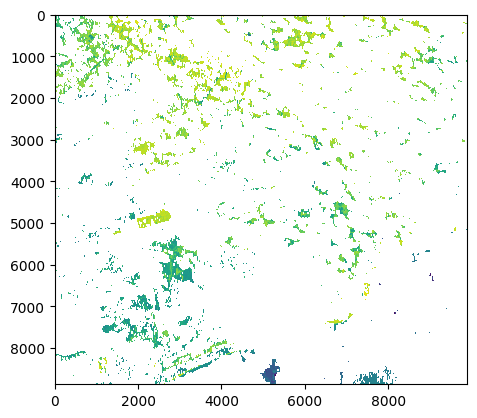

In [7]:
## ảnh ndvi chưa fill nan
plt.imshow(ndvi.isel(time=6))

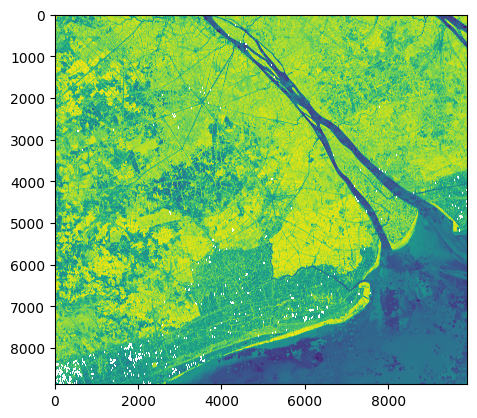

In [8]:
# đặt thời gian các mùa
time_split = [slice('2022-10-01', '2023-01-01'), 
               slice('2023-01-01', '2023-05-01'),
               slice('2023-05-01', '2023-07-01'),
               slice('2023-07-01', '2023-10-01')]

# fill nan
fill_nan_ndvi = fill_nan(ndvi, time_split)

## ảnh ndivi đã fill nan
plt.imshow(fill_nan_ndvi.isel(time=6))

In [11]:
%%time
## tính ndvi theo tháng
average_ndvi = fill_nan_ndvi.resample(time='1M').mean().persist()
progress(average_ndvi)

CPU times: user 1.84 s, sys: 1.92 ms, total: 1.84 s
Wall time: 1.84 s


VBox()

2024-08-26 07:31:07,496 - distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client


In [13]:
# compute average_ndvi
average_ndvi = average_ndvi.compute()

## cấu hình dữ liệu train và vh vv file
train_path = "train/ST_training data_updated_1130points.shp"  # đường dẫn shp file train
name_vh = "vh-0922_0923-full_ST.tif"
name_vv = "vv-0922_0923-full_ST.tif"

## load dữ liệu điểm train
train = load_train_data(train_path)
train.head()

,No,X,Y,LU2022,Hientrang,HT_code,geometry
0,1.0,603860.819,1081162.862,Pomelo,CLN,5,POINT (603860.819 1081162.862)
1,2.0,601306.410,1082782.940,Pomelo,CLN,5,POINT (601306.410 1082782.940)
2,3.0,601084.510,1081351.870,Pomelo,CLN,5,POINT (601084.510 1081351.870)
3,4.0,602193.760,1079205.220,Pomelo,CLN,5,POINT (602193.760 1079205.220)
4,5.0,602459.000,1080946.000,Pomelo,CLN,5,POINT (602459.000 1080946.000)


In [14]:
%%time
## tải về dữ liệu sen1
import os
if not os.path.exists(name_vh):
    !aws s3 cp s3://easi-asia-dc-data/staging/ctu/sentinel-1/vh-0922_0923-full_ST.tif vh-0922_0923-full_ST.tif
if not os.path.exists(name_vv):
    !aws s3 cp s3://easi-asia-dc-data/staging/ctu/sentinel-1/vv-0922_0923-full_ST.tif vv-0922_0923-full_ST.tif

CPU times: user 648 µs, sys: 0 ns, total: 648 µs
Wall time: 479 µs


In [15]:
# load dữ liệu sen1
dsvh, dsvv = load_sen1(name_vh, name_vv)

# xây dựng tập dataset
datasets = get_data_sen1_and_sen2(train, average_ndvi, dsvh, dsvv)

Warning 1: TIFFReadDirectory:Invalid data type for tag StripByteCounts
Warning 1: TIFFFetchNormalTag:ASCII value for tag "GeoASCIIParams" contains null byte in value; value incorrectly truncated during reading due to implementation limitations
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Invalid data type for tag StripByteCounts
Warning 1: TIFFFetchNormalTag:ASCII value for tag "GeoASCIIParams" contains null byte in value; value incorrectly truncated during reading due to implementation limitations
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


In [16]:
# cấu hình nhãn dữ liệu
label_mapping = {
    "Lua tom": "0",
    "Lua": "1",
    "CHN": "2",
    "CLN": "3",
    "TS": "4",
    "Song": "5",
    "Dat xay dung": "6",
    "Rung": "7"
}

# chia tập dữ liệu train, val, test
X_train, X_val, X_test, y_train, y_val, y_test = split_train_data(train, label_mapping, datasets)

In [17]:
# Huấn luyện mô hình
grid_search = train_with_rf(X_train, X_val, y_train, y_val)

Best Parameters: {'classifier__criterion': 'gini', 'classifier__max_depth': 8, 'classifier__n_estimators': 1000}
Accuracy: 83.0 %


In [18]:
# kiểm tra độ chính xác với tập test
y_pred_test = grid_search.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred_test)
print(f"Accuracy for test data {round(test_accuracy, 2)*100} %")

Accuracy for test data 87.0 %


In [19]:
# Lưu mô hình huấn luyện
save_model("model.joblib", grid_search)

Done!


In [20]:
# đóng client, cluster
client.close()
cluster.close()